<a href="https://colab.research.google.com/github/Leslyndizeye/Ubuzima_Connect/blob/main/notebooks/UbuzimaConnect_build_gate_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
DISEASE_ROOT = "/content/drive/MyDrive/ubuzima_datasets/disease"   # final output
GATE_ROOT    = "/content/drive/MyDrive/ubuzima_datasets/gate"      #

SEED = 42

# Targets
TARGET_TRAIN_PER_CLASS = 3000
TARGET_VAL_PER_CLASS   = 400
TARGET_TEST_PER_CLASS  = 400

# Gate dataset size
GATE_TRAIN_POS = 4000   # CXR
GATE_TRAIN_NEG = 4000   # Not-Chest X-RAYS
GATE_VAL_POS   = 500
GATE_VAL_NEG   = 500
GATE_TEST_POS  = 500
GATE_TEST_NEG  = 500

# Imports

In [5]:
!pip install kagglehub --quiet
!pip install tensorflow opencv-python matplotlib pandas scikit-learn --quiet

import os, shutil, random
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import kagglehub

from google.colab import drive
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [6]:
random.seed(SEED)
np.random.seed(SEED)

drive.mount("/content/drive")
print("Drive mounted ")
def reset_dir(path):
    if os.path.exists(path):
        shutil.rmtree(path)
    os.makedirs(path, exist_ok=True)

# Reset dataset roots
reset_dir(DISEASE_ROOT)
reset_dir(GATE_ROOT)

# Disease structure
disease_classes = ["Normal", "Pneumonia", "Tuberculosis", "Unknown"]
for split in ["train", "val", "test"]:
    for c in disease_classes:
        os.makedirs(os.path.join(DISEASE_ROOT, split, c), exist_ok=True)

# Gate structure
gate_classes = ["CXR", "NotCXR"]
for split in ["train", "val", "test"]:
    for c in gate_classes:
        os.makedirs(os.path.join(GATE_ROOT, split, c), exist_ok=True)

print("Folders created ")
print("Disease:", DISEASE_ROOT)
print("Gate:", GATE_ROOT)

Mounted at /content/drive
Drive mounted 
Folders created 
Disease: /content/drive/MyDrive/ubuzima_datasets/disease
Gate: /content/drive/MyDrive/ubuzima_datasets/gate


# Downloading datasets

In [7]:
print("Downloading NIH ChestX-ray14...")
nih_path = kagglehub.dataset_download("nih-chest-xrays/data")

print("Downloading TB dataset...")
tb_path = kagglehub.dataset_download("tawsifurrahman/tuberculosis-tb-chest-xray-dataset")

print("Downloading Random images (Not-CXR)...")
rand_path = kagglehub.dataset_download("pankajkumar2002/random-image-sample-dataset")

print(" NIH:", nih_path)
print(" TB:", tb_path)
print(" RAND:", rand_path)

100%|██████████| 42.0G/42.0G [07:22<00:00, 102MB/s] 

Extracting files...


Using Colab cache for faster access to the 'tuberculosis-tb-chest-xray-dataset' dataset.
Using Colab cache for faster access to the 'random-image-sample-dataset' dataset.
 NIH: /root/.cache/kagglehub/datasets/nih-chest-xrays/data/versions/3
 TB: /kaggle/input/tuberculosis-tb-chest-xray-dataset
 RAND: /kaggle/input/random-image-sample-dataset


# Mapping NIH dataset images locations

In [8]:
print("Mapping NIH images...")
nih_img_map = {}
for root, dirs, files in os.walk(nih_path):
    for f in files:
        if f.lower().endswith(".png"):
            nih_img_map[f] = os.path.join(root, f)

print("NIH images found:", len(nih_img_map))

Mapping NIH images...
NIH images found: 112120


# Strong preprocessing

In [9]:
def preprocess_and_save(src_path, dst_path):
    img = cv2.imread(src_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return False

    img = cv2.resize(img, (512, 512))
    img = cv2.GaussianBlur(img, (3, 3), 0)  # mild denoise

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    img = clahe.apply(img)

    # safe crop to reduce borders/text overlays
    crop = 24
    img = img[crop:-crop, crop:-crop]
    img = cv2.resize(img, (512, 512))

    cv2.imwrite(dst_path, img)
    return True

# Load NIH CSV + build labeled lists

In [10]:
csv_path = os.path.join(nih_path, "Data_Entry_2017.csv")
df = pd.read_csv(csv_path)

# Building image lists
normal_df = df[df["Finding Labels"] == "No Finding"].copy()
pneu_df   = df[df["Finding Labels"].str.contains("Pneumonia", na=False)].copy()

unknown_df = df[
    (df["Finding Labels"] != "No Finding") &
    (~df["Finding Labels"].str.contains("Pneumonia", na=False))
].copy()

print("NIH rows:", len(df))
print("Normal:", len(normal_df))
print("Pneumonia:", len(pneu_df))
print("Unknown(other findings):", len(unknown_df))

# Use Patient ID for patient-wise split
assert "Patient ID" in df.columns, "NIH CSV must contain Patient ID"

NIH rows: 112120
Normal: 60361
Pneumonia: 1431
Unknown(other findings): 50328


# Patient-wise split function (core academic part)

In [11]:
def patientwise_split(class_df, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1):
    patients = class_df["Patient ID"].unique().tolist()
    random.shuffle(patients)

    n = len(patients)
    n_train = int(n * train_ratio)
    n_val   = int(n * val_ratio)

    train_p = set(patients[:n_train])
    val_p   = set(patients[n_train:n_train+n_val])
    test_p  = set(patients[n_train+n_val:])

    train_imgs = class_df[class_df["Patient ID"].isin(train_p)]["Image Index"].tolist()
    val_imgs   = class_df[class_df["Patient ID"].isin(val_p)]["Image Index"].tolist()
    test_imgs  = class_df[class_df["Patient ID"].isin(test_p)]["Image Index"].tolist()

    random.shuffle(train_imgs)
    random.shuffle(val_imgs)
    random.shuffle(test_imgs)
    return train_imgs, val_imgs, test_imgs

# Building splits (NIH classes)

In [12]:
n_train, n_val, n_test = patientwise_split(normal_df)
p_train, p_val, p_test = patientwise_split(pneu_df)
u_train, u_val, u_test = patientwise_split(unknown_df)

print("Normal splits:", len(n_train), len(n_val), len(n_test))
print("Pneumonia splits:", len(p_train), len(p_val), len(p_test))
print("Unknown splits:", len(u_train), len(u_val), len(u_test))

Normal splits: 48256 6125 5980
Pneumonia splits: 1138 135 158
Unknown splits: 40669 4549 5110


TB spliting (file-based, no patient IDs available)

In [13]:
# Locating TB folder
tb_src = None
for root, dirs, files in os.walk(tb_path):
    if "Tuberculosis" in dirs:
        tb_src = os.path.join(root, "Tuberculosis")
        break
    if "TB" in dirs:
        tb_src = os.path.join(root, "TB")
        break

if tb_src is None:
    raise FileNotFoundError("TB folder not found in TB dataset.")

tb_files = [os.path.join(tb_src, f) for f in os.listdir(tb_src)
            if f.lower().endswith((".png", ".jpg", ".jpeg"))]
random.shuffle(tb_files)

tb_train, tb_temp = train_test_split(tb_files, test_size=0.2, random_state=SEED)
tb_val, tb_test   = train_test_split(tb_temp, test_size=0.5, random_state=SEED)

print("TB splits:", len(tb_train), len(tb_val), len(tb_test))

TB splits: 560 70 70


# Saving base images to folders (NO augmentation yet)

In [14]:
def save_nih_images(img_list, out_dir, limit):
    saved = 0
    for name in img_list:
        if saved >= limit:
            break
        if name in nih_img_map:
            dst = os.path.join(out_dir, name)
            if preprocess_and_save(nih_img_map[name], dst):
                saved += 1
    return saved

def save_tb_images(path_list, out_dir, limit):
    saved = 0
    for src in path_list:
        if saved >= limit:
            break
        base = os.path.basename(src)
        dst = os.path.join(out_dir, base if base.lower().endswith(".png") else base + ".png")
        if preprocess_and_save(src, dst):
            saved += 1
    return saved

# Save NIH base
normal_saved_train = save_nih_images(n_train, os.path.join(DISEASE_ROOT, "train", "Normal"), min(TARGET_TRAIN_PER_CLASS, 3000))
normal_saved_val   = save_nih_images(n_val,   os.path.join(DISEASE_ROOT, "val", "Normal"),   TARGET_VAL_PER_CLASS)
normal_saved_test  = save_nih_images(n_test,  os.path.join(DISEASE_ROOT, "test","Normal"),   TARGET_TEST_PER_CLASS)

pneu_saved_train = save_nih_images(p_train, os.path.join(DISEASE_ROOT, "train", "Pneumonia"), min(len(p_train), 1500))
pneu_saved_val   = save_nih_images(p_val,   os.path.join(DISEASE_ROOT, "val", "Pneumonia"),   min(TARGET_VAL_PER_CLASS, len(p_val)))
pneu_saved_test  = save_nih_images(p_test,  os.path.join(DISEASE_ROOT, "test","Pneumonia"),   min(TARGET_TEST_PER_CLASS, len(p_test)))

unk_saved_train = save_nih_images(u_train, os.path.join(DISEASE_ROOT, "train", "Unknown"), min(len(u_train), 2000))
unk_saved_val   = save_nih_images(u_val,   os.path.join(DISEASE_ROOT, "val", "Unknown"),   TARGET_VAL_PER_CLASS)
unk_saved_test  = save_nih_images(u_test,  os.path.join(DISEASE_ROOT, "test","Unknown"),   TARGET_TEST_PER_CLASS)

# Saving TB base
tb_saved_train = save_tb_images(tb_train, os.path.join(DISEASE_ROOT, "train", "Tuberculosis"), 700)
tb_saved_val   = save_tb_images(tb_val,   os.path.join(DISEASE_ROOT, "val", "Tuberculosis"),   min(TARGET_VAL_PER_CLASS, len(tb_val)))
tb_saved_test  = save_tb_images(tb_test,  os.path.join(DISEASE_ROOT, "test","Tuberculosis"),   min(TARGET_TEST_PER_CLASS, len(tb_test)))

print("Saved base counts:")
print("Normal:", normal_saved_train, normal_saved_val, normal_saved_test)
print("Pneumonia:", pneu_saved_train, pneu_saved_val, pneu_saved_test)
print("Unknown:", unk_saved_train, unk_saved_val, unk_saved_test)
print("TB:", tb_saved_train, tb_saved_val, tb_saved_test)

Saved base counts:
Normal: 3000 400 400
Pneumonia: 1138 135 158
Unknown: 2000 400 400
TB: 560 70 70


In [ ]:
# No horizontal flip (safer for CXR)
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_ran ge=0.1,
    horizontal_flip=False,
    fill_mode="nearest"
)

def augment_to_target(train_class_dir, target):
    files = [f for f in os.listdir(train_class_dir) if f.lower().endswith(".png")]
    count = len(files)
    if count == 0:
        raise ValueError(f"Empty folder: {train_class_dir}")

    print(f"Augmenting {os.path.basename(train_class_dir)} from {count} to {target}...")
    i = 0
    while count < target:
        f = files[i % len(files)]
        img = cv2.imread(os.path.join(train_class_dir, f), cv2.IMREAD_GRAYSCALE)
        if img is None:
            i += 1
            continue

        x = img.reshape((1, 512, 512, 1))
        for _ in datagen.flow(x, batch_size=1, save_to_dir=train_class_dir, save_prefix="aug", save_format="png"):
            count += 1
            break
        i += 1
    print(" Done:", count)

for c in ["Pneumonia", "Tuberculosis", "Unknown", "Normal"]:
    augment_to_target(os.path.join(DISEASE_ROOT, "train", c), TARGET_TRAIN_PER_CLASS)

# Build Gate dataset (CXR vs Not-CXR)

In [ ]:
# Collect CXR positives from NIH + TB TRAIN sets (already processed images)
cxr_sources = []
for c in ["Normal", "Pneumonia", "Unknown", "Tuberculosis"]:
    d = os.path.join(DISEASE_ROOT, "train", c)
    cxr_sources += [os.path.join(d, f) for f in os.listdir(d) if f.lower().endswith(".png")]
random.shuffle(cxr_sources)

# Collect Not-CXR negatives from random dataset
rand_imgs = []
for root, dirs, files in os.walk(rand_path):
    for f in files:
        if f.lower().endswith((".png", ".jpg", ".jpeg", ".webp")):
            rand_imgs.append(os.path.join(root, f))
random.shuffle(rand_imgs)

print("CXR candidates:", len(cxr_sources))
print("Not-CXR candidates:", len(rand_imgs))

# Saving Gate split folders

In [ ]:
def save_gate_imgs(src_paths, out_dir, limit):
    saved = 0
    for i, src in enumerate(src_paths[:limit]):
        dst = os.path.join(out_dir, f"img_{i}.png")
        if preprocess_and_save(src, dst):
            saved += 1
    return saved

# Gate: train
pos_train = save_gate_imgs(cxr_sources, os.path.join(GATE_ROOT, "train", "CXR"), GATE_TRAIN_POS)
neg_train = save_gate_imgs(rand_imgs,  os.path.join(GATE_ROOT, "train", "NotCXR"), GATE_TRAIN_NEG)

# Gate: val
pos_val = save_gate_imgs(cxr_sources[GATE_TRAIN_POS:], os.path.join(GATE_ROOT, "val", "CXR"), GATE_VAL_POS)
neg_val = save_gate_imgs(rand_imgs[GATE_TRAIN_NEG:],   os.path.join(GATE_ROOT, "val", "NotCXR"), GATE_VAL_NEG)

# Gate: test
pos_test = save_gate_imgs(cxr_sources[GATE_TRAIN_POS+GATE_VAL_POS:], os.path.join(GATE_ROOT, "test", "CXR"), GATE_TEST_POS)
neg_test = save_gate_imgs(rand_imgs[GATE_TRAIN_NEG+GATE_VAL_NEG:],   os.path.join(GATE_ROOT, "test", "NotCXR"), GATE_TEST_NEG)

print("Gate saved:")
print("Train:", pos_train, neg_train)
print("Val:", pos_val, neg_val)
print("Test:", pos_test, neg_test)

# sample display


=== Disease Dataset Summary ===
TRAIN
  Normal 3000
  Pneumonia 2837
  Tuberculosis 2726
  Unknown 2953
VAL
  Normal 400
  Pneumonia 135
  Tuberculosis 70
  Unknown 400
TEST
  Normal 400
  Pneumonia 158
  Tuberculosis 70
  Unknown 400

=== Gate Dataset Summary ===
TRAIN
  CXR 4000
  NotCXR 3000
VAL
  CXR 500
  NotCXR 0
TEST
  CXR 500
  NotCXR 0


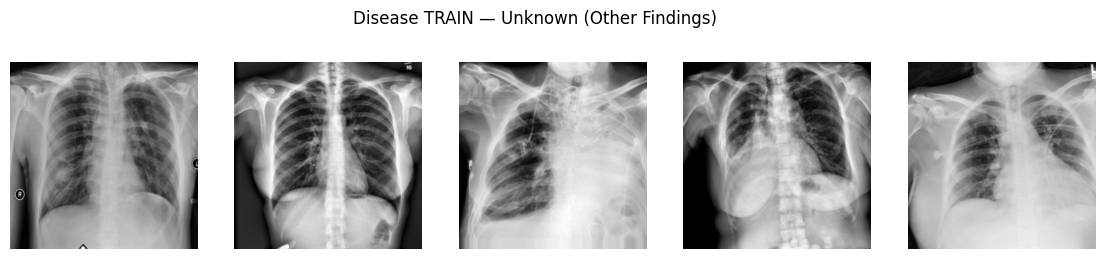

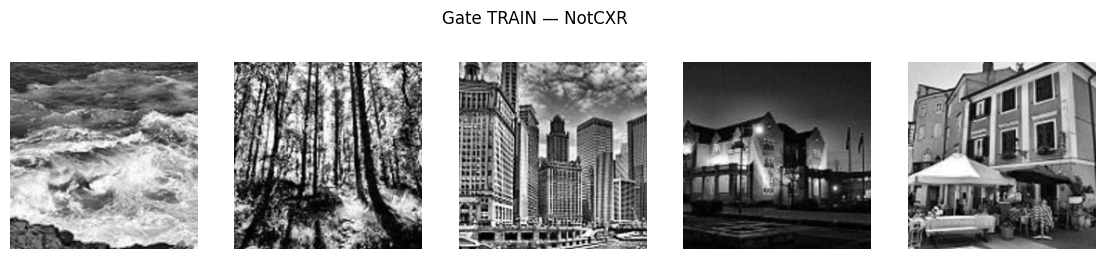

In [18]:
def count_pngs(folder):
    return len([f for f in os.listdir(folder) if f.lower().endswith(".png")])

print("\n=== Disease Dataset Summary ===")
for split in ["train","val","test"]:
    print(split.upper())
    for c in disease_classes:
        print(" ", c, count_pngs(os.path.join(DISEASE_ROOT, split, c)))

print("\n=== Gate Dataset Summary ===")
for split in ["train","val","test"]:
    print(split.upper())
    for c in gate_classes:
        print(" ", c, count_pngs(os.path.join(GATE_ROOT, split, c)))

def show_samples(folder, title, n=5):
    files = [f for f in os.listdir(folder) if f.lower().endswith(".png")]
    sample = random.sample(files, min(n, len(files)))
    plt.figure(figsize=(14,3))
    for i,f in enumerate(sample):
        img = cv2.imread(os.path.join(folder,f), cv2.IMREAD_GRAYSCALE)
        plt.subplot(1,n,i+1)
        plt.imshow(img, cmap="gray")
        plt.axis("off")
    plt.suptitle(title)
    plt.show()

show_samples(os.path.join(DISEASE_ROOT,"train","Unknown"), "Disease TRAIN — Unknown (Other Findings)")
show_samples(os.path.join(GATE_ROOT,"train","NotCXR"), "Gate TRAIN — NotCXR")